# Exercise 6

## Question 1

Last week, we have implemented k-means. For this week, we will implement its variance called k-medoids.

In [18]:
from __future__ import print_function, division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn import preprocessing
from sklearn.datasets import make_blobs

np.random.seed(42)

%matplotlib inline

def euclidean_distance(point, centroid):
    return np.sqrt(np.sum((point - centroid)**2))

### SOLUTION

Complete the method `choose_centroids` below. Specifically:  

*  `choose_centroids(X, labels, num_clusters)` choose a new centroid from the data points in a cluster. The new centroid is the data point that has the lowest sum of distances to other points in the cluster (recall that assignement is represented by the `labels` array).


In [2]:
"""
Calculate the centroid or mean of all objects in each cluster.
"""
def choose_centroids(X, labels, num_clusters):
    centroids = []
    for i in range(num_clusters):
        points = X[labels == i]
        centroid = points[0]
        min_dis = sum(euclidean_distance(centroid, p) for p in points)/len(points)
        for candidate_centroid in points:
            dis = sum(euclidean_distance(candidate_centroid, p) for p in points)/len(points)
            if dis < min_dis:
                min_dis = dis
                centroid = candidate_centroid
        centroids.append(centroid)
    return np.array(centroids)

In [3]:
"""
Generate random 2D data points
"""
def gen_data(num_samples,num_blobs=3,random_state=42):
    X, y = make_blobs(n_samples=num_samples, random_state=random_state, centers=num_blobs, cluster_std=5.0)
    return X,y

"""
Compute euclidean distance between a point and a centroid.
point,centroid: 1D Numpy array containing coordinates [x,y]
"""

def init_centroids(X,num_clusters):
    rand_indices = np.random.choice(X.shape[0], num_clusters,replace=False)
    return X[rand_indices,:]

"""
Assign objects to their closest cluster center according to the Euclidean distance function.
"""
def assign_points(X, centroids):
    labels = []
    for point in range(0, X.shape[0]):
        distance = {}
        for centroid in range(0, centroids.shape[0]):
            distance[centroid] = euclidean_distance(X[point], centroids[centroid])
        
        index_of_minimum = min(distance, key=distance.get)
        labels.append(index_of_minimum)
    return np.array(labels)
    
def k_medoids(X, num_clusters):

    # Initialize centroids to randomly chosen data points
    centroids  = init_centroids(X,num_clusters)

    # Bookkeeping
    num_iter  = 0
    positions = [centroids]
    
    while True:
        
        labels = assign_points(X, centroids)
        
        new_centroids = choose_centroids(X, labels, num_clusters)
        
        # Termination criterion
        if np.all(centroids == new_centroids):
            break
            
        centroids = new_centroids
        positions.append(centroids)
        num_iter += 1
        
    return [labels, centroids, num_iter, positions]

In [4]:
num_samples = 150
num_blobs   = 3
X,y = gen_data(num_samples,num_blobs=num_blobs)

total_iterations = 10
num_clusters     = 3
[cluster_label, new_centroids, num_iter, positions] = k_medoids(X,num_clusters)
print("Convergence in %i iteration(s)" % num_iter)

Convergence in 3 iteration(s)


### Plotting

Cluster centroids are displayed as red circles. Their positions across the various steps of the optimization are displayed as red lines. Data points are colored according to their cluster assignement.

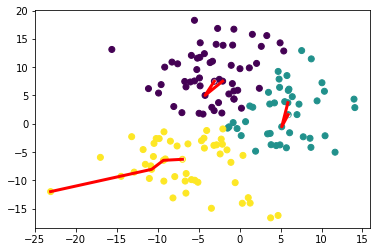

In [5]:
_ = plt.scatter(X[:, 0], X[:, 1], c=cluster_label)
_ = plt.scatter(new_centroids[:,0], new_centroids[:,1], marker='o', s=5, c='r', edgecolors='w', linewidths=2)

plt.plot(np.array(positions)[:,0,0],np.array(positions)[:,0,1],'r',linewidth=3)
plt.plot(np.array(positions)[:,1,0],np.array(positions)[:,1,1],'r',linewidth=3)
plt.plot(np.array(positions)[:,2,0],np.array(positions)[:,2,1],'r',linewidth=3)

## Question 2

Complete the following method to compute the modularity measure of a graph.

If you haven't installed networkx package, you can run the following command (note the exclamation mark)
```python
!conda install networkx --yes
```

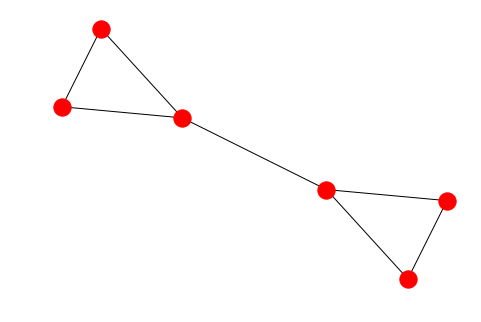

In [5]:
import networkx as nx
import numpy as np

%matplotlib inline

M = ["0,1,2",
"1,0,2",
"2,0,1,3",
"3,2,4,5",
"4,3,5",
"5,3,4"
    ]
G=nx.parse_adjlist(M, nodetype=int, delimiter=",")
nx.draw(G)

#G = nx.karate_club_graph()
#nx.draw(G)

In [13]:
for node in [0,1,2]:
    G.nodes[node]['community'] = 0
for node in [3,4,5]:
    G.nodes[node]['community'] = 1
G.degree[2]
len(G.edges)

7

In [23]:
# The community label of a node can be accessed by G[node_id]['community']
# The degree of a node: G.degree[node_id]
# The neighbors of a node: G.neighbors(node_id)
# Number of edges between 2 nodes: G.number_of_edges(node_1, node_2)
def compute_modularity(G):
    m = len(G.edges)
    Q = 0
    for node_i in G.nodes:
        for node_j in G.nodes:
            if node_j != node_i and G.nodes[node_i]['community'] == G.nodes[node_j]['community']:
#                 print(node_i, node_j)
                Q += G.number_of_edges(node_i, node_j) - G.degree[node_i]*G.degree[node_j]/(2*m)
    return Q/(2*m)

compute_modularity(G)

0.5306122448979591

## Pen and Paper

Suppose that you have an undirected social graph G = (U, V), where U - set of nodes, V - set of edges.

<img src="graph.png" width="400">

#### Question 2

Compute betweenness for the graph G and output the communities for the following betweenness threshold : 4, 6.

#### SOLUTION

Following the Girvan- Newman algorithm, first we visit each node X once and compute the number of shortest paths from X to each of the other nodes. To do so, we run BFS starting at node X.

##### Compute Betweenness - Path Counting:

Let’s assume we start from the node E. Label each node by the number of shortest paths that reach it from the root ($N_{shortest}$). So, we label the root with 1. We continue top-down. D and F have one parent so they are labeled by the score of their parent. Similarly for B, A and C. However, G has two parents, thus its label is equal to 2. Finally, we need to calculate for each edge e the fraction of shortest paths from X to Y that go through e, e.g., from E to all other nodes.

![alt text](path.png "Title")

#### Compute Betweenness - Edge Flow:

1. The flow that arrives at every node is 1.
2. In addition each node receives the flow of its children. The flow of its children is distributed over the parents, proportionally to the number of paths that are leading to those parents (previous stage). For example: B: 1 + (1+1) = 3. F = 1 + (½) = 1.5

![alt text](flow.png "Title")

To complete the calculation we need to apply the procedure to every node as the root and sum the contributions. Finally, we need to divide the credit for each edge by 2 since every shortest path is discovered twice, once for each of its endpoints. The final betweenness scores for the edges are the following. 

![alt text](flow2.png "Title")

Thus, we obtain the following clusters for the betweenness of 4 and 6.

![alt text](b4.png "Title")

![alt text](b6.png "Title")
